<img src="./img/uomlogo.png" align="left"/><br><br>
# PHYS20762 - Project 2

Dominik Szablonski<br>
University of Manchester  
February 2025

We first initialise our interpreter.

In [1]:
from ipywidgets import *
import matplotlib.pyplot as plt
import string
from math import *
import numpy as np
from random import randint

plt.rcParams.update({'font.size': 14})
plt.style.use('default')

Our equation of motion is,

$$mx''(t) + bx'(t) + kx(t) = F(t)$$

where $k = 1.87$kg s$^{-2}$ and $m = 4.01$kg. We will choose $b = 1$. We initialise these parameters,

In [2]:
K = 1.87 # kg / s^2
M = 4.01 # kg
B = 0.5

We will now also intialise our initial values as well as the step and the number of steps for each method.

In [3]:
X_0 = 0
V_0 = -1
A_0 = -(B/M)*V_0 - (K/M)*X_0
TIME = 100
STEP = 0.05
STEPS = int(TIME/STEP)

We will now begin to attempt to solve the equation above, first by assuming $F(t) = 0$.

# Euler Method
For the euler method, let us write our equation of motion,

$$x'' + \frac{b}{m}x' + \frac{k}{m}x = 0$$

and let us define $v = x'$ and $a = x''$. If we consider a samll time step $h$, we then have,

$$x_{i+1} = x_i + hv_{i}$$
$$v_{i+1} = v_i + ha_i = \left(1 - \frac{b}{m}\right)v_i -\frac{kh}{m}x_i$$
$$a_i = -\frac{b}{m}v_i - \frac{k}{m}x_i.$$

In [4]:
def euler(step=STEP, steps=STEPS):
    x_array = np.zeros(steps)
    v_array = np.zeros(steps)
    
    x_array[0] = X_0
    v_array[0] = V_0
    
    for i in range(1, steps):
        a = -(K/M)*x_array[i-1] - (B/M)*v_array[i-1]
        
        x_array[i] = x_array[i-1] + step*v_array[i-1]
        v_array[i] = v_array[i-1] + a*step

    return x_array, v_array

x_euler, v_euler = euler()

# Improved Euler

We can add an additional term in our Taylor expansion, so that we have,

$$x_{i+1} = x_i + hv_i + \frac{h^2}{2}a_i = \left(1 - \frac{h^2k}{2m}\right)x_i + \left(h - \frac{h^2b}{2m}\right)v_i$$
$$v_{i+1} = v_i + ha_i = \left(1 - \frac{b}{m}\right)v_i -\frac{kh}{m}x_i$$
$$a_i = -\frac{b}{m}v_i - \frac{k}{m}x_i.$$

In [5]:
def improved_euler(step=STEP,steps=STEPS):    
    x_array = np.zeros(steps)
    v_array = np.zeros(steps)
    
    x_array[0] = X_0
    v_array[0] = V_0

    for i in range(1, steps):
        a = -(K/M)*x_array[i-1] - (B/M)*v_array[i-1]
        
        x_array[i] = x_array[i-1] + step*v_array[i-1] + ((step**2)/2)*a
        v_array[i] = v_array[i-1] + step*a

    return x_array, v_array

x_improved_euler, v_improved_euler = improved_euler()

# Verlet Method

## Algorithm Theory
For the Verlet method, we consider a centered derivative,

$$x'(t) = \lim_{h \to 0} \frac{x(t + h) - x(t - h)}{2h}$$

and perform two Taylor expansions,

$$x(t + h) = x(t) + hx'(t) + \frac{1}{2}h^2x''(t) + \mathcal{O}(h^3)$$
$$x(t - h) = x(t) - hx'(t) + \frac{1}{2}h^2x''(t) + \mathcal{O}(h^3)$$

Subtracting these and rearranging them can give us expressions for the approximate forms of the first and second derivatives,
$$x'(t) = \frac{x(t + h) - x(t - h)}{2h} + \mathcal{O}(h^2)$$
$$x'(t) = \frac{x(t + h) - x(t - h) -2x(t)}{h^2} + \mathcal{O}(h^2)$$

If $h$ is our time step, we can consider $x(t + h) = x_{i+1}$ and $x(t-h) = x_{i-1}$. We can then rearrange to obtain subsequent steps,

$$x_{i+1} = 2x_i - x_{i-1} + h^2 a_i + \mathcal{O}(h^4)$$
$$a_i = -\frac{k}{m}x_i - \frac{b}{m}v_i$$
$$v_i = \frac{x_{i+1} - x_{i-1}}{2h}$$

which gives an expression for subsequent steps which is quartic in $h$, so is more accurate than other methods. However, we are unable to compute this system of equations seperately, as we need to know $v_i$ and $x_{i+1}$ simulatenously to get one or the other. So, we can combine the equation above to get a single expression for the evolution of $x$,

$$x_{i+1} = \frac{2(2m - kh^2)}{2m+bh}x_i + \frac{bh - 2m}{2m + bh}x_{i-1}$$

which we can parametrise as below,

\begin{align}
A = \frac{2(2m - kh^2)}{D} && B = \frac{bh - 2m}{D} && D = 2m + bh
\end{align}

to get,

$$x_{i+1} = Ax_i + Bx_{i-1}$$

## Limitations
At the beginning of the simulation, we require knowledge of two initial values of $x$, $x_0$ and $x_{1}$. We have no way of finding the second value via our algorithm, so we must resort to a different method. We will be using the improved Euler method as described in the previous section to obtain the second initial value in our simulation.

In [6]:
def verlet(step=STEP, steps=STEPS):
    D = 2*M + B*step
    A = (2*(2*M - K*(step**2)))/D
    C = (B*step - 2*M)/D

    X_next = lambda x_current, x_previous : A*x_current + C*x_previous
    V_next = lambda x_next, x_previous : (x_next - x_previous)/(2*step)

    x_array = np.zeros(steps)
    v_array = np.zeros(steps)
    
    x_array[0] = X_0
    x_array[1] = X_0 + V_0*step + 0.5*A_0*(step**2)
    
    for i in range(1, steps - 1):
        x_array[i+1] = X_next(x_array[i], x_array[i-1])

    # Once all x is known, calculate v.
    v_array[0] = V_0

    v_array[1:-1] = (x_array[2:] - x_array[:-2]) / (2*step)
    
    # Calculate additional x term
    x_last = X_next(x_array[-1], x_array[-2])
    v_array[-1] = V_next(x_last, x_array[-1])
    
    return x_array, v_array
    
x_verlet, v_verlet = verlet()

# Euler-Cromer 
## Energy under the Euler method
Let us analyse the trend of kinetic energy with the Euler method,

thus we find that the energy of the system increases with time under the Euler method.

## Euler-Cromer algorithm
We can change the Euler method slightly in order to have the energy decrease.

$$x_{i+1} = x_i + hv_{i+1}$$
$$v_{i+1} = v_i + ha_{i} = \left(1 - \frac{bh}{m}\right)v_i - \frac{k}{m}x_i$$

In [7]:
def euler_cromer(step=STEP, steps=STEPS):
    x_array = np.zeros(steps)
    v_array = np.zeros(steps)
    
    x_array[0] = X_0
    v_array[0] = V_0
    
    for i in range(1, steps):
        a = -(K/M)*x_array[i-1] - (B/M)*v_array[i-1]

        v_array[i] = v_array[i-1] + a*step
        x_array[i] = x_array[i-1] + step*v_array[i]

    return x_array, v_array

x_euler_cromer, v_euler_cromer = euler_cromer()

# Analytic Solution
The analytic solution of a damped, unforced harmonic oscillator with the initial condition $x(0) = 0$ is,

$$x(t) = A_0 e^{-\frac{b}{2m}t}\sin(\omega t + \phi),$$

where.

$$\omega = \sqrt{\frac{k}{m} - \left(\frac{b}{2m}\right)^2}.$$

If $v(0) = V_0$, then it follows that $A_0 = \frac{V_0}{\omega}$.

We will require the velocity later when we analyse energies, so,

$$\dot{x}(t) = \frac{V_0}{\omega}\left(-\frac{b}{2m}\sin(\omega t + \phi) + \omega\cos(\omega t + \phi)\right)e^{-\frac{b}{2m}t}$$

In [8]:
omega = np.sqrt((K/M) - (B/(2*M))**2)

def analytic_x(t):
    x = (V_0/omega)*np.exp(-(B/(2*M))*t) * np.sin(omega * t)

    return x

def analytic_v(t):
    v = (V_0/omega)*(-(B/(2*M))*np.sin(omega*t) + omega*np.cos(omega*t))*np.exp(-(B/(2*M))*t)

    return v

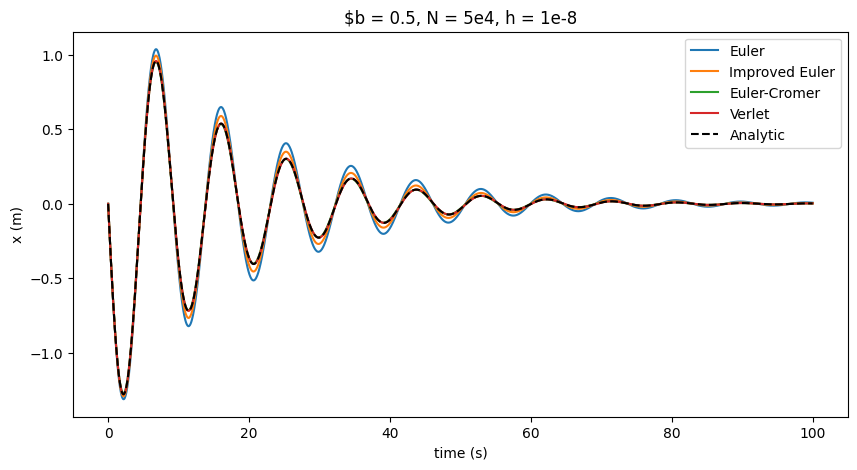

In [9]:
t = np.linspace(0,STEPS*STEP,num=STEPS)
    
# tweeking the figure size
plt.rcParams["figure.figsize"] = (10,5)
plt.figure()
# plotting mean radius data against time with error bars
plt.plot(t, x_euler, "-", label="Euler")
plt.plot(t, x_improved_euler, "-", label="Improved Euler")
plt.plot(t, x_euler_cromer, "-", label="Euler-Cromer")
plt.plot(t, x_verlet, "-", label="Verlet")
plt.plot(t, analytic_x(t), "k--", label="Analytic")
# setting axis labels & figures 
plt.xlabel("time (s)")
plt.ylabel("x (m)")
plt.legend()
plt.title("$b = 0.5, N = 5e4, h = 1e-8")
# displaying the plot
plt.show()

# Optimising
We wish to now find the best possible numerical integration method for the given problem. We will first discuss errors which are outside of our control but which we can attempt to minimise, i.e., computing errors. We will then attempt to optimise our numerical integration, first by minimising round-off error for each method by finding the optimal step size $h$. We will then consider which method represents the energy of the system most appropriately to quantify the best integration method.

## Floating Point Error

## Range Error

## Round-Off Error
We can find the optimal time step $h$ for a given approximation $F(x,h)$ of a function $f(x)$ by considering the time step which minimises the difference between the function and the approximation, i.e.,

$$\Delta(h) = \left|f(x) - F(x,h)\right|$$

Let us write a function which computes $\Delta(h)$ for a given time step $h$,

In [10]:
exponents = np.arange(-13,-7,dtype=float)
h_val = 10**exponents
h = h_val
def Delta(approximating_function, step, steps):  
    index = -1
    
    t = np.linspace(0,steps*step,num=steps)
    analytic = analytic_x(t)
    #print(approximating_function(step,steps))
    approx, v = approximating_function(step,steps)
    #print(f"{anal} - {approximating_function(step, steps)[index]} ={np.abs(anal - approximating_function(step, steps)[index])}")
    return np.abs(analytic[index] - approx[index])

def get_h(approx, time):
    h_array = np.array([])

    print(time/h_val)
    
    h_array = np.array([Delta(approx, h, int(time/h)) for h in h_val])

    return h_array

euler_delta = get_h(euler, 0.0000001)
improved_euler_delta = get_h(improved_euler, 0.0000001)
euler_cromer_delta = get_h(euler_cromer, 0.0000001)

exponents = np.arange(-9,-2,dtype=float)
h_val = 10**exponents
verlet_delta = get_h(verlet, 0.01)

[1.e+06 1.e+05 1.e+04 1.e+03 1.e+02 1.e+01]
[1.e+06 1.e+05 1.e+04 1.e+03 1.e+02 1.e+01]
[1.e+06 1.e+05 1.e+04 1.e+03 1.e+02 1.e+01]
[1.e+07 1.e+06 1.e+05 1.e+04 1.e+03 1.e+02 1.e+01]


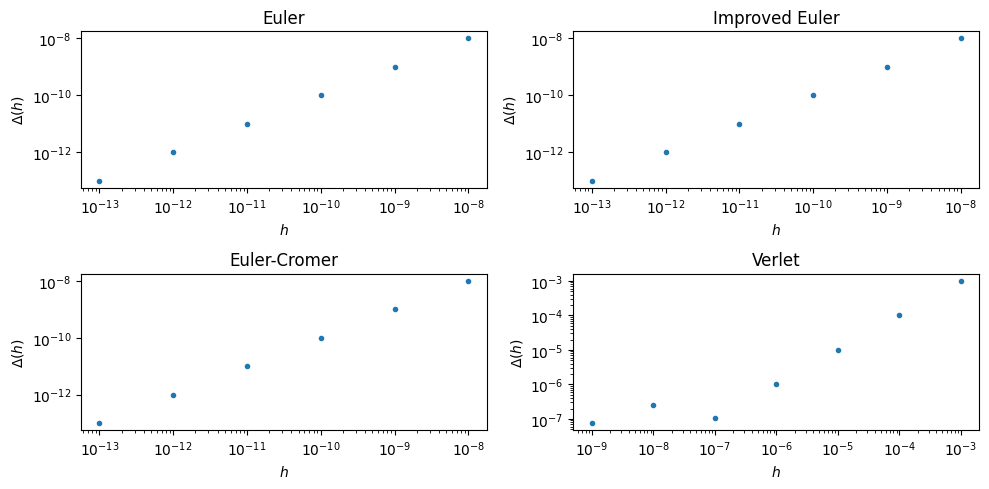

In [11]:
# tweeking the figure size
plt.rcParams["figure.figsize"] = (10,5)
fig = plt.figure()
# plotting mean radius data against time with error bars
#plt.plot(t, x_euler, "-", label="Euler")
#plt.plot(t, x_improved_euler, "-", label="Improved Euler")
ax=plt.subplot2grid((2,2), (0,0))
dot, = ax.plot(h, euler_delta, ".")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Euler")
ax.set_ylabel(r"$\Delta(h)$")
ax.set_xlabel("$h$")


ax1 = plt.subplot2grid((2,2), (0,1))
dot, = ax1.plot(h, improved_euler_delta, ".")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("$h$")
ax1.set_title("Improved Euler",y=1)
ax1.set_ylabel(r"$\Delta(h)$")

ax2 = plt.subplot2grid((2,2), (1,1))
dot, = ax2.plot(h_val, verlet_delta, ".")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("$h$")
ax2.set_title("Verlet",y=1)
ax2.set_ylabel(r"$\Delta(h)$")

ax3 = plt.subplot2grid((2,2), (1,0))
dot, = ax3.plot(h, euler_cromer_delta, ".")
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_xlabel("$h$")
ax3.set_title("Euler-Cromer",y=1)
ax3.set_ylabel(r"$\Delta(h)$")

fig.tight_layout()
#plt.xlabel("h")
#plt.ylabel(r"\Delta(h)")
#plt.title("Experimental Data")

# displaying the plot
plt.show()

## Energy of the Oscillator
The total energy of the oscillator is described,

$$E = \frac{1}{2}kx^2 + \frac{1}{2}mv^2$$

In [12]:
t = np.linspace(0,STEPS*STEP,num=STEPS)

def energy(x,v):
    potential = (1/2)*K*x**2
    kinetic = (1/2)*M*v**2

    return kinetic + potential

energy_euler = energy(x_euler, v_euler)
energy_euler_improved = energy(x_improved_euler, v_improved_euler)
energy_verlet = energy(x_verlet, v_verlet)
energy_euler_cromer = energy(x_euler_cromer, v_euler_cromer)
energy_analytic = energy(analytic_x(t), analytic_v(t))

Let's plot this.

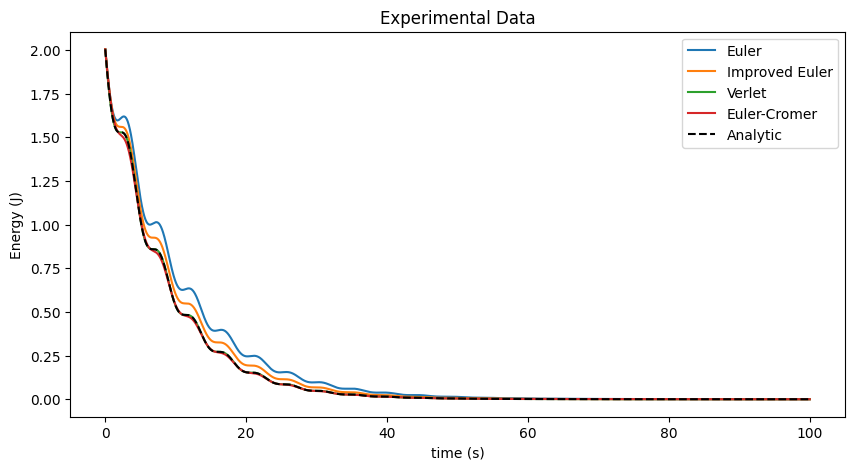

In [13]:

# tweeking the figure size
plt.rcParams["figure.figsize"] = (10,5)
plt.figure()
# plotting mean radius data against time with error bars
plt.plot(t, energy_euler, "-", label="Euler")
plt.plot(t, energy_euler_improved, "-", label="Improved Euler")
plt.plot(t, energy_verlet, "-", label="Verlet")
plt.plot(t, energy_euler_cromer, "-", label="Euler-Cromer")
plt.plot(t, energy_analytic, "k--", label="Analytic")
# setting axis labels & figures 
plt.xlabel("time (s)")
plt.ylabel("Energy (J)")
plt.title("Experimental Data")
plt.legend()
# displaying the plot
plt.show()

We

In [14]:
exponents = np.arange(-13,-7,dtype=float)
h_val = np.append(10**exponents, (5)*(10**(exponents-1)))

h = h_val
def Delta(approximating_function, step, steps):  
    index = -1
    
    t = np.linspace(0,steps*step,num=steps)
    analytic = energy(analytic_x(t), analytic_v(t))
    #print(approximating_function(step,steps))
    x, v = approximating_function(step,steps)
    approx = energy(x,v)
    #print(f"{anal} - {approximating_function(step, steps)[index]} ={np.abs(anal - approximating_function(step, steps)[index])}")
    return np.abs(analytic[index] - approx[index])

def get_h(approx, time):
    h_array = np.array([])

    print(time/h_val)
    
    h_array = np.array([Delta(approx, h, int(time/h)) for h in h_val])

    return h_array

euler_delta = get_h(euler, 0.0000001)
improved_euler_delta = get_h(improved_euler, 0.0000001)
euler_cromer_delta = get_h(euler_cromer, 0.0000001)

exponents = np.arange(-8,0,dtype=float)
h_val = np.append(10**exponents, 5*(10**exponents))
verlet_delta = get_h(verlet, 1)

[1.e+06 1.e+05 1.e+04 1.e+03 1.e+02 1.e+01 2.e+06 2.e+05 2.e+04 2.e+03
 2.e+02 2.e+01]
[1.e+06 1.e+05 1.e+04 1.e+03 1.e+02 1.e+01 2.e+06 2.e+05 2.e+04 2.e+03
 2.e+02 2.e+01]
[1.e+06 1.e+05 1.e+04 1.e+03 1.e+02 1.e+01 2.e+06 2.e+05 2.e+04 2.e+03
 2.e+02 2.e+01]
[1.e+08 1.e+07 1.e+06 1.e+05 1.e+04 1.e+03 1.e+02 1.e+01 2.e+07 2.e+06
 2.e+05 2.e+04 2.e+03 2.e+02 2.e+01 2.e+00]


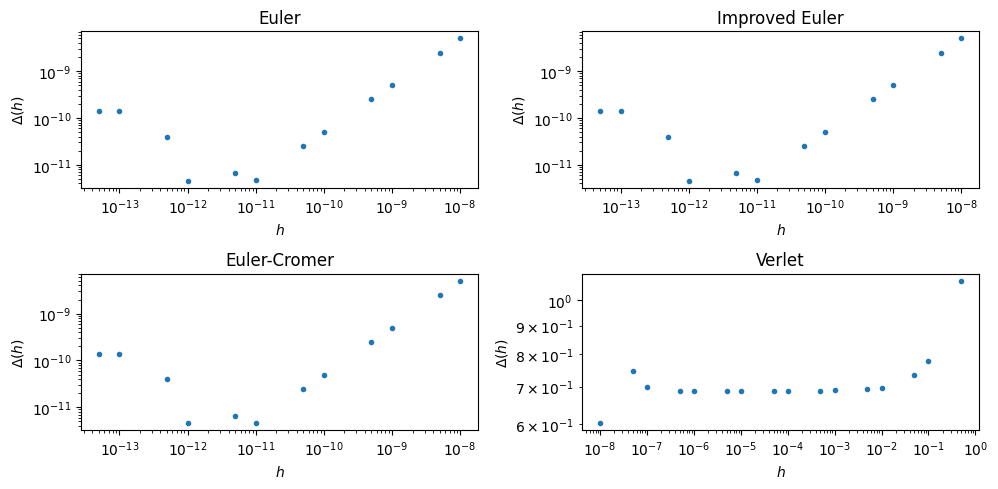

In [15]:
# tweeking the figure size
plt.rcParams["figure.figsize"] = (10,5)
fig = plt.figure()
# plotting mean radius data against time with error bars
#plt.plot(t, x_euler, "-", label="Euler")
#plt.plot(t, x_improved_euler, "-", label="Improved Euler")
ax=plt.subplot2grid((2,2), (0,0))
dot, = ax.plot(h, euler_delta, ".")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Euler")
ax.set_ylabel(r"$\Delta(h)$")
ax.set_xlabel("$h$")


ax1 = plt.subplot2grid((2,2), (0,1))
dot, = ax1.plot(h, improved_euler_delta, ".")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("$h$")
ax1.set_title("Improved Euler",y=1)
ax1.set_ylabel(r"$\Delta(h)$")

ax2 = plt.subplot2grid((2,2), (1,1))
dot, = ax2.plot(h_val, verlet_delta, ".")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("$h$")
ax2.set_title("Verlet",y=1)
ax2.set_ylabel(r"$\Delta(h)$")

ax3 = plt.subplot2grid((2,2), (1,0))
dot, = ax3.plot(h, euler_cromer_delta, ".")
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_xlabel("$h$")
ax3.set_title("Euler-Cromer",y=1)
ax3.set_ylabel(r"$\Delta(h)$")

fig.tight_layout()
#plt.xlabel("h")
#plt.ylabel(r"\Delta(h)")
#plt.title("Experimental Data")

# displaying the plot
plt.show()

Now that we know the optimal step, let us compare the average $\Delta(h)$ over time for the optimal step for each method over the energy.